# Distributions of all the events in the dataset

In [75]:
import numpy as np
import os
from tqdm import tqdm
from multiprocessing import Pool
from matplotlib import pyplot as plt

In [76]:
N_EVENTS = 50000

In [ ]:
folder_path = "/scratch3/salonso/faser/events_v3.5"  
output_folder = "."
os.makedirs(output_folder, exist_ok=True)

In [78]:
#create a fuction to compute the value of the normo fht emomentum form the x,y,z components
def module(x,y,z):
    return np.sqrt(x**2 + y**2 + z**2)

In [80]:
import numpy as np
import os
from tqdm import tqdm
from multiprocessing import Pool

# Function to load multiple variables from a .npz file
def load_variables(file_variables_tuple):
    """Loads the specified variables from a .npz file."""
    file, variable_names = file_variables_tuple
    try:
        with np.load(file) as data:
            return {var: data[var] if var in data else None for var in variable_names}
    except Exception as e:
        print(f"Error loading {file}: {e}")
        return {var: None for var in variable_names}

# Main function to extract multiple variables
def load_variables_from_npz(folder_path, variable_names, num_files, num_workers=16):
    """
    Load multiple variables from .npz files using multiprocessing.

    Returns:
        dict: A dictionary where keys are variable names and values are NumPy arrays.
    """

    # Get list of .npz files
    file_list = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.npz')]
    file_list = file_list[:num_files]  # Limit to requested files

    # Prepare arguments for multiprocessing
    file_variables_tuples = [(file, variable_names) for file in file_list]

    # Use multiprocessing
    num_workers = min(num_workers, os.cpu_count() or 1)
    with Pool(processes=num_workers) as pool:
        data_list = list(tqdm(pool.imap(load_variables, file_variables_tuples), total=len(file_list), desc="Processing files"))

    # Convert list of dictionaries into a dictionary of lists
    data_dict = {var: [] for var in variable_names}
    for entry in data_list:
        for var in variable_names:
            if entry[var] is not None:
                data_dict[var].append(entry[var])

    # Convert lists to NumPy arrays
    for var in data_dict:
        try:
            # If all elements have the same shape, create a standard NumPy array
            sample_shape = set(arr.shape for arr in data_dict[var] if arr is not None)
            if len(sample_shape) == 1:
                data_dict[var] = np.array(data_dict[var], dtype=np.float32)
            else:
                # Store variable-length arrays as dtype=object
                data_dict[var] = np.array(data_dict[var], dtype=object)
        except Exception as e:
            print(f"Error processing variable {var}: {e}")

    return data_dict

# Function to save filtered events into separate files
def save_filtered_data(data_dict, output_folder):
    """
    Saves the extracted data into four separate .npz files based on interaction type.
    """

    is_cc = data_dict['is_cc'].astype(bool)  # Convert to boolean array
    in_neutrino_pdg = data_dict['in_neutrino_pdg'].astype(int)  # Convert to int array

    # Define masks for event selection
    mask_nc = ~is_cc  # NC events (is_cc is False)
    mask_cc_e = is_cc & np.isin(in_neutrino_pdg, [12, -12])  # CC with ν_e / ν̅_e
    mask_cc_mu = is_cc & np.isin(in_neutrino_pdg, [14, -14])  # CC with ν_μ / ν̅_μ
    mask_cc_tau = is_cc & np.isin(in_neutrino_pdg, [16, -16])  # CC with ν_τ / ν̅_τ

    # Store filtered data
    for mask, filename in zip(
        [mask_nc, mask_cc_e, mask_cc_mu, mask_cc_tau],
        ["nc_events.npz", "cc_nue_events.npz", "cc_numu_events.npz", "cc_nutau_events.npz"]
    ):
        filtered_data = {var: values[mask] for var, values in data_dict.items()}
        np.savez_compressed(os.path.join(output_folder, filename), **filtered_data)
        print(f"Saved {filename} with {filtered_data['is_cc'].shape[0]} events.")



In [81]:
# Define variables to extract (including is_cc and in_neutrino_pdg for filtering)
variables_to_extract = ['is_cc', 'in_neutrino_pdg', 
                        'e_vis', 'sp_momentum', 'vis_sp_momentum', 'jet_momentum', 'pt_miss',
                        'in_neutrino_momentum', 'in_neutrino_energy',
                        'out_lepton_momentum', 'out_lepton_energy',
                        'rear_cal_energy', 'rear_hcal_energy', 'rear_mucal_energy','faser_cal_energy']

# Load data
data_dict = load_variables_from_npz(folder_path, variables_to_extract, num_files=N_EVENTS)

Processing files: 100%|██████████| 50000/50000 [05:57<00:00, 139.80it/s] 


In [82]:
#transform the sp_momentum into the module of the vector
def module(x,y,z):
    return np.sqrt(x**2 + y**2 + z**2)

#print the shape of the data
for key in data_dict.keys():
    print(key, data_dict[key].shape)

data_dict['sp_momentum'] = module(data_dict['sp_momentum'][:,0],data_dict['sp_momentum'][:,1],data_dict['sp_momentum'][:,2])
data_dict['vis_sp_momentum'] = module(data_dict['vis_sp_momentum'][:,0],data_dict['vis_sp_momentum'][:,1],data_dict['vis_sp_momentum'][:,2])
data_dict['jet_momentum'] = module(data_dict['jet_momentum'][:,0],data_dict['jet_momentum'][:,1],data_dict['jet_momentum'][:,2])
data_dict['in_neutrino_momentum'] = module(data_dict['in_neutrino_momentum'][:,0],data_dict['in_neutrino_momentum'][:,1],data_dict['in_neutrino_momentum'][:,2])
data_dict['out_lepton_momentum'] = module(data_dict['out_lepton_momentum'][:,0],data_dict['out_lepton_momentum'][:,1],data_dict['out_lepton_momentum'][:,2])


# Save filtered data into separate .npz files
save_filtered_data(data_dict, output_folder)

is_cc (50000,)
in_neutrino_pdg (50000,)
e_vis (50000,)
sp_momentum (50000, 3)
vis_sp_momentum (50000, 3)
jet_momentum (50000, 3)
pt_miss (50000,)
in_neutrino_momentum (50000, 3)
in_neutrino_energy (50000,)
out_lepton_momentum (50000, 3)
out_lepton_energy (50000,)
rear_cal_energy (50000,)
rear_hcal_energy (50000,)
rear_mucal_energy (50000,)
faser_cal_energy (50000,)
Saved nc_events.npz with 12917 events.
Saved cc_nue_events.npz with 6309 events.
Saved cc_numu_events.npz with 30624 events.
Saved cc_nutau_events.npz with 150 events.


# Plotting

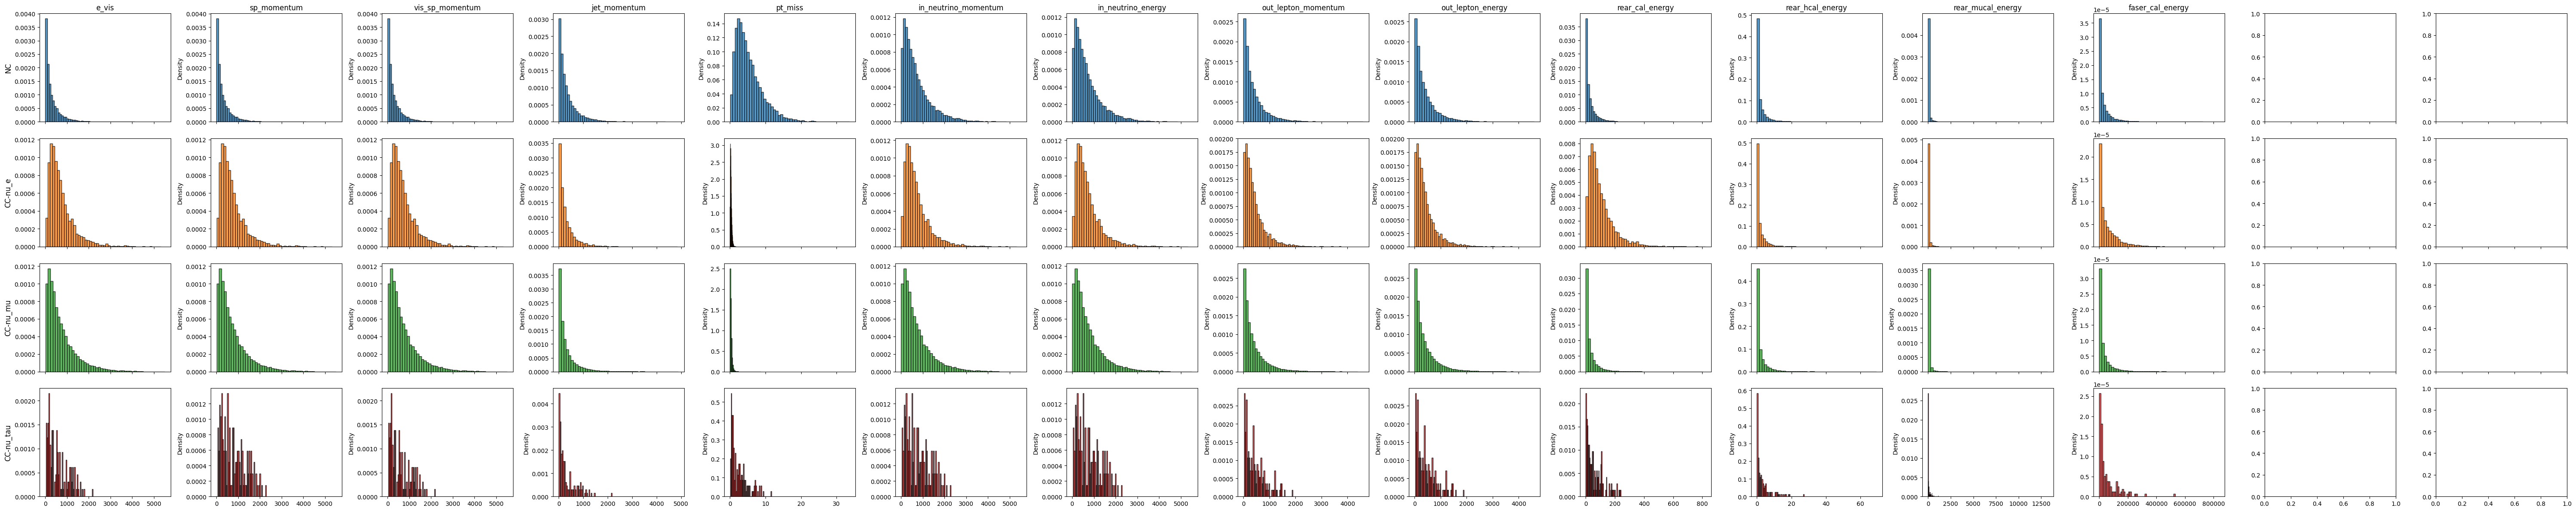

In [83]:
# Load the data
data_cc_e = np.load("cc_nue_events.npz")
data_cc_mu = np.load("cc_numu_events.npz")
data_cc_tau = np.load("cc_nutau_events.npz")
data_nc = np.load("nc_events.npz")

# Get the variable names (assuming all files have the same variables)
variables = list(data_nc.keys())

# Define number of columns (one for each variable)
num_cols = len(variables)

# Create the figure and subplots (4 rows, N columns)
fig, axes = plt.subplots(nrows=4, ncols=num_cols, figsize=(4 * num_cols, 12), sharex='col')

# Titles for each row
row_titles = ["NC", "CC-nu_e", 
              "CC-nu_mu", "CC-nu_tau"]

plt_varialbes = ['e_vis', 'sp_momentum', 'vis_sp_momentum', 'jet_momentum', 'pt_miss',
                 'in_neutrino_momentum', 'in_neutrino_energy',
                 'out_lepton_momentum', 'out_lepton_energy',
                 'rear_cal_energy', 'rear_hcal_energy', 'rear_mucal_energy','faser_cal_energy']
# Plot the data
for col, var in enumerate(plt_varialbes):
    # Define subplot for each interaction type
    for row, (data, title) in enumerate(zip([data_nc, data_cc_e, data_cc_mu, data_cc_tau], row_titles)):
        ax = axes[row, col] if num_cols > 1 else axes[row]  # Handle single-variable case
        ax.hist(data[var], bins=50, alpha=0.75, color='C'+str(row), edgecolor='black', density=True)
        ax.set_ylabel("Density")
        if row == 0:
            ax.set_title(var, fontsize=12)
        if col == 0:
            ax.set_ylabel(title, fontsize=12)

# Adjust layout
plt.tight_layout()
plt.savefig('histograms.png')
plt.show()

# RECO HITS

In [ ]:
#now the reco_hits
# Load the data
variables_to_extract = ['reco_hits','is_cc', 'in_neutrino_pdg']
data_dict = load_variables_from_npz(folder_path, variables_to_extract, num_files=N_EVENTS)

Processing files:  81%|████████  | 40522/50000 [03:45<01:08, 139.37it/s]

In [ ]:
data_dict["reco_hits"] = np.vstack(data_dict["reco_hits"])[:N_EVENTS]

In [ ]:
#DIVIDE THE DATA INTO THE DIFFERENT INTERACTIONS
is_cc = data_dict['is_cc'].astype(bool)  # Convert to boolean array
in_neutrino_pdg = data_dict['in_neutrino_pdg'].astype(int)  # Convert to int array

# Define masks for event selection
mask_nc = ~is_cc  # NC events (is_cc is False)
mask_cc_e = is_cc & np.isin(in_neutrino_pdg, [12, -12])  # CC with ν_e / ν̅_e
mask_cc_mu = is_cc & np.isin(in_neutrino_pdg, [14, -14])  # CC with ν_μ / ν̅_μ
mask_cc_tau = is_cc & np.isin(in_neutrino_pdg, [16, -16])  # CC with ν_τ / ν̅_τ

#save into different variables
data_nc = {var: values[mask_nc] for var, values in data_dict.items()}
data_cc_e = {var: values[mask_cc_e] for var, values in data_dict.items()}
data_cc_mu = {var: values[mask_cc_mu] for var, values in data_dict.items()}
data_cc_tau = {var: values[mask_cc_tau] for var, values in data_dict.items()}

reco_hits (3559, 6)
is_cc (3559,)
in_neutrino_pdg (3559,)


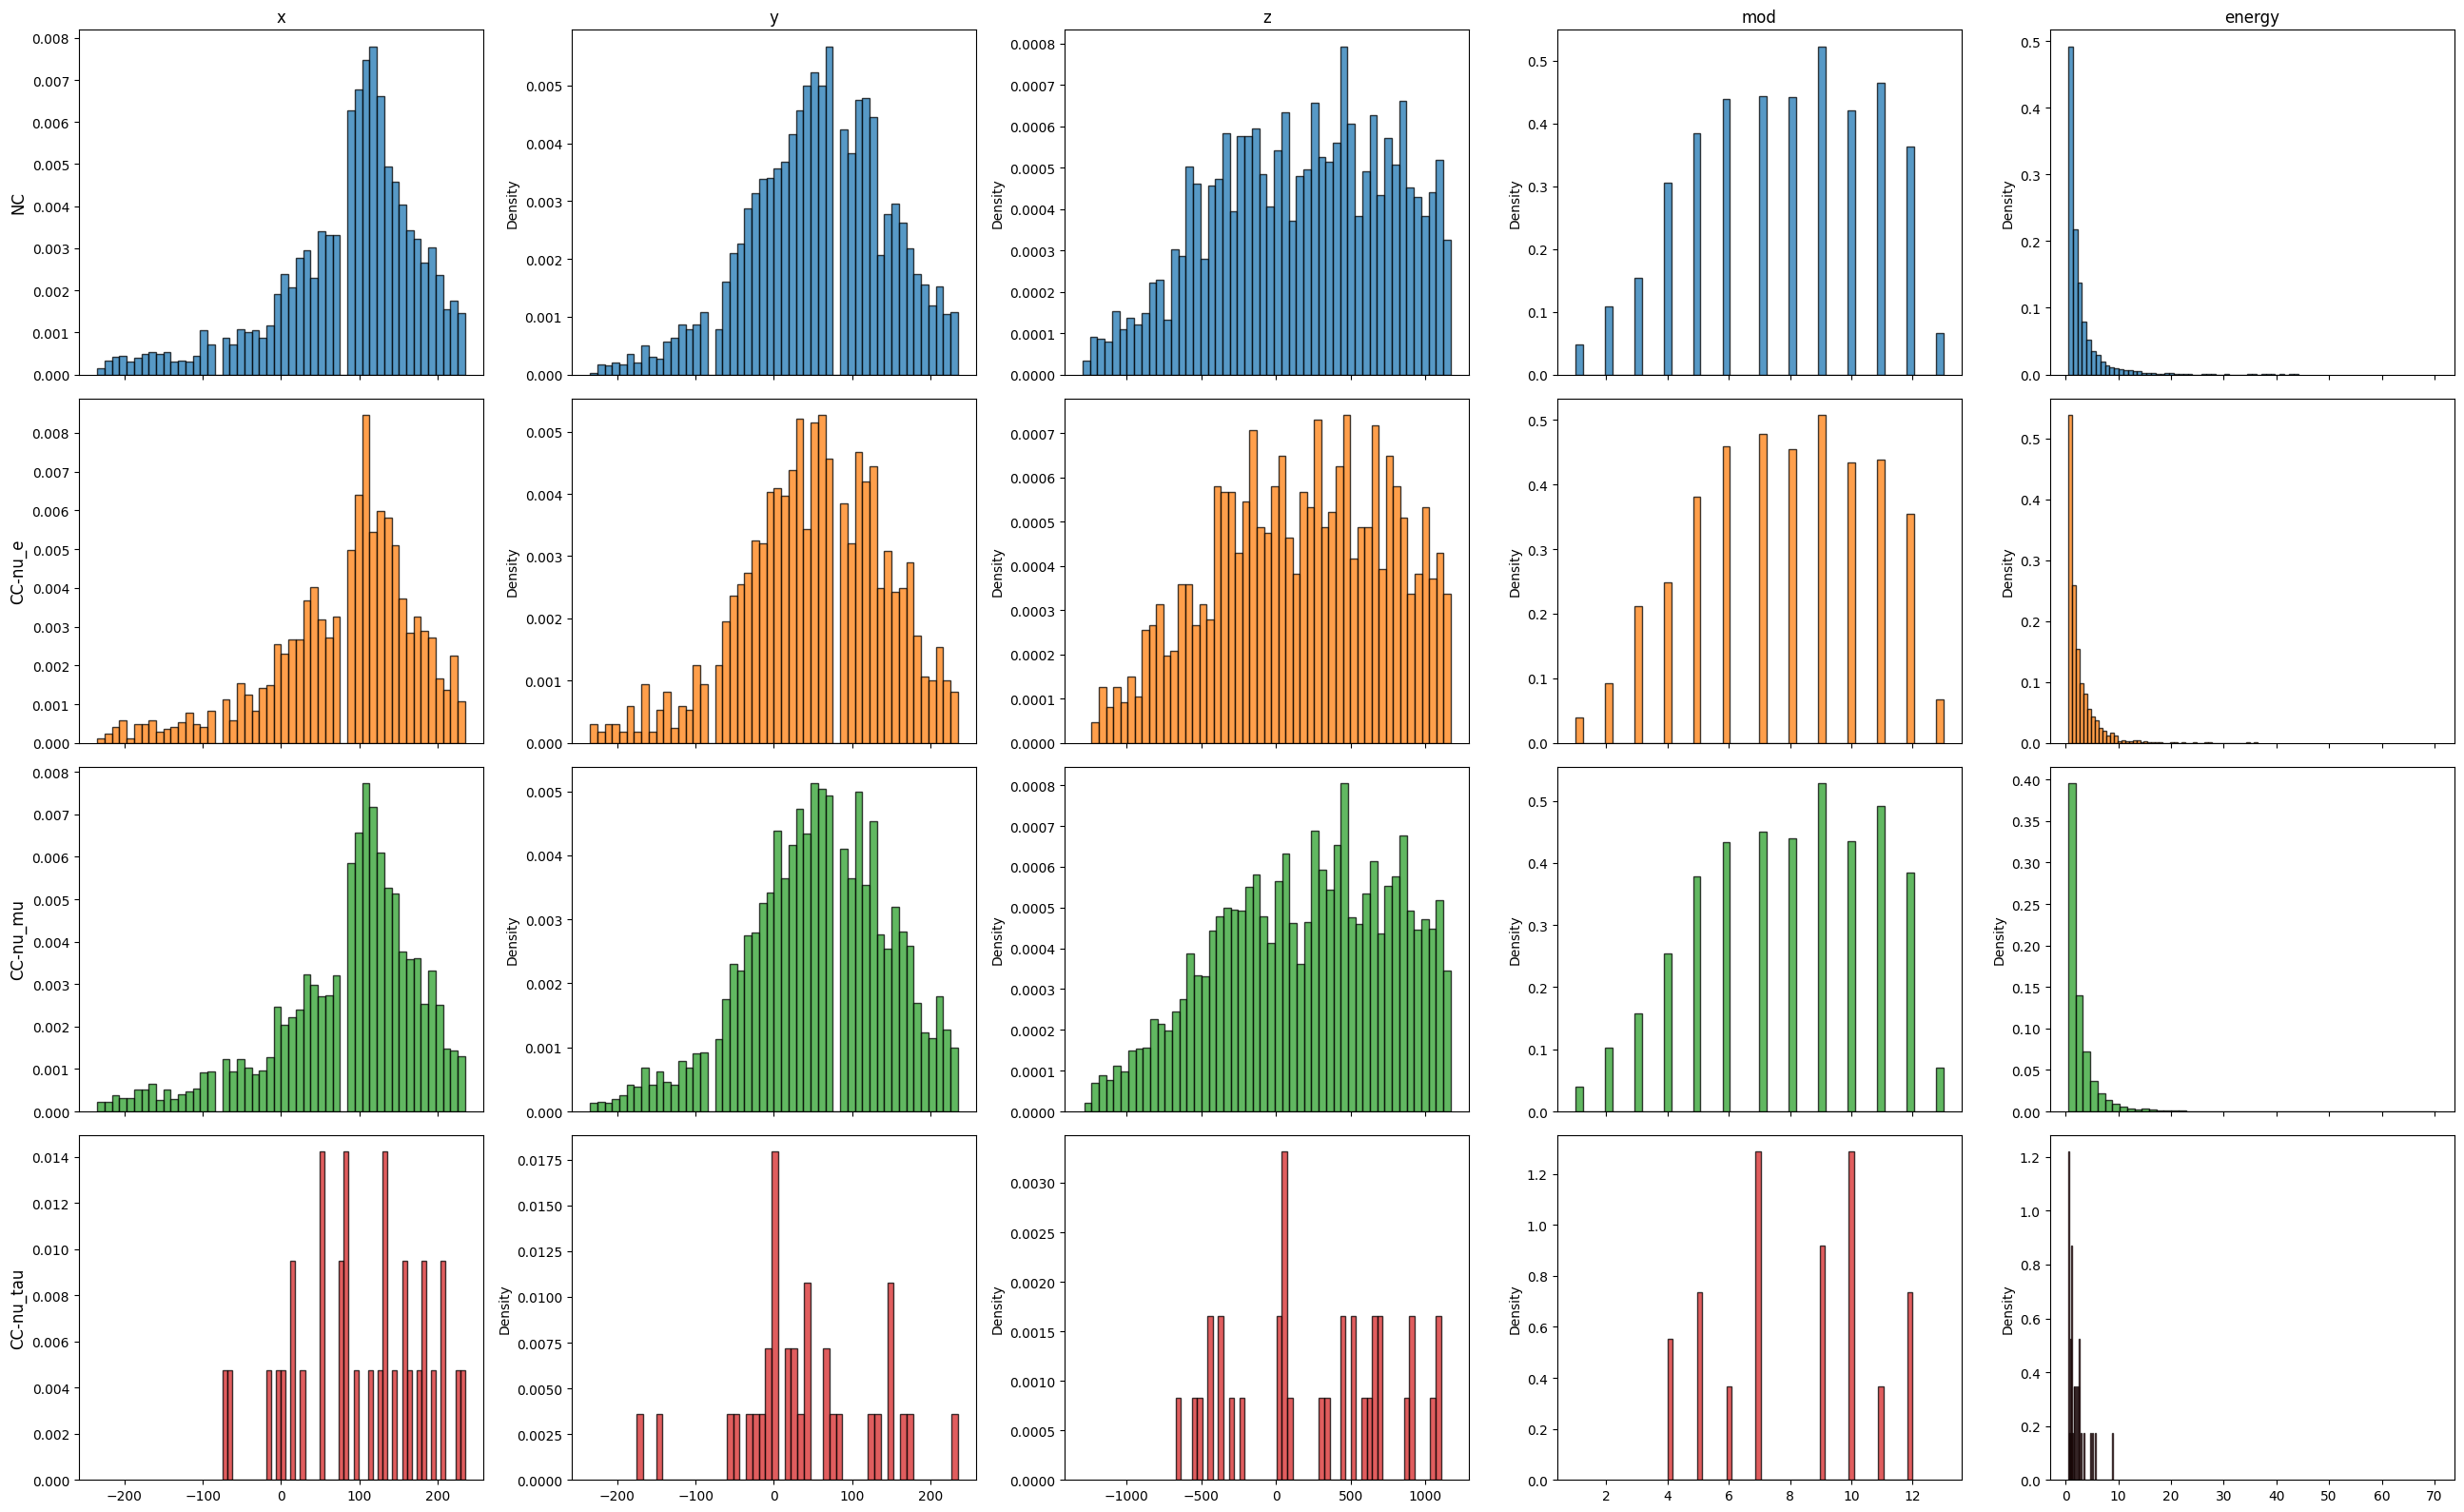

In [ ]:
#do the plot as before per interaction and per variable of the reco_hits

for key in data_nc.keys():
    print(key, data_nc[key].shape)

# Get the variable names (assuming all files have the same variables)
variables = ['x', 'y', 'z','mod', 'energy']

fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(26, 16), sharex='col')

# Titles for each row
row_titles = ["NC", "CC-nu_e", 
              "CC-nu_mu", "CC-nu_tau"]

# Plot the data
for col, var in enumerate(variables):
    # Define subplot for each interaction type
    for row, (data, title) in enumerate(zip([data_nc, data_cc_e, data_cc_mu, data_cc_tau], row_titles)):
        ax = axes[row, col] if len(variables) > 1 else axes[row]  # Handle single-variable case
        ax.hist(data["reco_hits"][:, col].flatten(), bins=50, alpha=0.75, color='C'+str(row), edgecolor='black', density=True)
        ax.set_ylabel("Density")
        if row == 0:
            ax.set_title(var, fontsize=12)
        if col == 0:
            ax.set_ylabel(title, fontsize=12)

# Adjust layout
plt.tight_layout()
plt.savefig('histograms_hits.png')
plt.show()